In [1]:
import h5py
import hdf5plugin
import bslz4_to_sparse
import numpy as np
from time import time
import scipy
import blosc2
import sys
import matplotlib.pyplot as plt

In [2]:
N = 10
with h5py.File("sparse_image_stack.h5", "r") as h5f:
    data_all = h5f["entry_0000/measurement/data"][:N]

In [3]:
h5f = h5py.File("sparse_images.h5", "r")
bslz4_dataset = h5f["bslz4"]

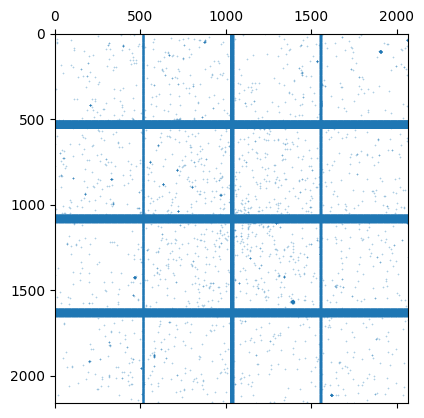

In [4]:
# How the data looks like
data = data_all[0]
plt.spy(data, markersize=0.1)

In [5]:
def array_to_sparse(array: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Convert an array to sparse representation"""
    array = np.ravel(array)
    indices = np.nonzero(array)[0]
    values = array[indices]
    return values, indices

In [6]:
# Sizes of the original and sparse representation
dsize = data.nbytes
print(f"Original size: {dsize / 1024**2:.2f} MB")

Original size: 17.06 MB


In [7]:
# Compression params for Blosc2
cplz4 = dict(clevel=9, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.LZ4)
cpzstd = dict(clevel=6, filters=[blosc2.Filter.SHUFFLE], codec=blosc2.Codec.ZSTD,  splitmode=blosc2.SplitMode.AUTO_SPLIT)
chunks = (2162, 2068)
blocks = (256 * 2, 256)
#blocks = None
#blocks = chunks

In [8]:
# Transform the numpy array to a blosc2 NDArray (which has special support for sparse arrays)
ctimes_lz4, ctimes_zstd = [], []
ctimes = {"Blosc2 + Shuffle + LZ4": [], "Blosc2 + Shuffle + Zstd": []}
b2im_lz4, b2im_zstd = [], []
for i in range(N):
    t0 = time()
    b2im_lz4.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cplz4))
    ctimes["Blosc2 + Shuffle + LZ4"].append(time() - t0)
    t0 = time()
    b2im_zstd.append(blosc2.asarray(data, chunks=chunks, blocks=blocks, cparams=cpzstd))
    ctimes["Blosc2 + Shuffle + Zstd"].append(time() - t0)

In [9]:
# Build a dict with different NDArrays
a = {"Blosc2 + Shuffle + LZ4": b2im_lz4, "Blosc2 + Shuffle + Zstd": b2im_zstd}
cratios = {"Blosc2 + Shuffle + LZ4": [], "Blosc2 + Shuffle + Zstd": []}
for k, v in a.items():
    for i in range(N):
        cbytes = v[i].schunk.cbytes
        cratio = dsize / cbytes
        #print(f"{k} chunk {i} size: {cbytes / 1024:.2f} KB ({cratio:.1f}x)")
        cratios[k].append(cratio)

In [10]:
# bslz4 cratio
cratios["bslz4"] = [dsize / len(bslz4_dataset.id.read_direct_chunk((i, 0, 0))[1]) for i in range(N)]

In [11]:
cratios |= {"LIL": [], "DOK": [], "CSR": [], "CSC": [], "COO": [], "BSR": []}
for i in range(N):
    lil = scipy.sparse.lil_array(data)
    data_size = sum(sys.getsizeof(x) for x in lil.data)
    rows_size = sum(sys.getsizeof(x) for x in lil.rows)
    lil_size = lil.data.nbytes + lil.rows.nbytes + data_size + rows_size
    cratio = dsize / lil_size
    cratios["LIL"].append(cratio)
    dok = lil.todok()
    dok_size = dok.size * (dok.dtype.itemsize + 8)  # 8 bytes for the key
    cratio = dsize / dok_size
    cratios["DOK"].append(cratio)
    csr = lil.tocsr()
    csr_size = csr.data.nbytes + csr.indices.nbytes + csr.indptr.nbytes
    cratio = dsize / csr_size
    cratios["CSR"].append(cratio)
    csc = lil.tocsc()
    csc_size = csc.data.nbytes + csc.indices.nbytes + csc.indptr.nbytes
    cratio = dsize / csc_size
    cratios["CSC"].append(cratio)
    coo = lil.tocoo()
    coo_size = coo.data.nbytes + coo.row.nbytes + coo.col.nbytes
    cratio = dsize / coo_size
    cratios["COO"].append(cratio)
    bsr = lil.tobsr()
    bsr_size = bsr.data.nbytes + bsr.indices.nbytes + bsr.indptr.nbytes
    cratio = dsize / bsr_size
    cratios["BSR"].append(cratio)

In [12]:
# Decompress (Blosc2)
dtimes_lz4, dtimes_zstd = [], []
dtimes = {"Blosc2 + Shuffle + LZ4": [], "Blosc2 + Shuffle + Zstd": []}
for k, v in a.items():
    for i in range(N):
        t0 = time()
        _ = v[i][:]
        dtimes[k].append((time() - t0) / N)
        # t = time() - t0
        #print(f"{k} decompression: {t * 1000:.2f} ms ({dsize / t / 1024**2:.2f} MB/s)")


In [13]:
ctimes_csr, ctimes_csc, ctimes_coo, ctimes_bsr = [], [], [], []
ctimes |= {"CSR": ctimes_csr, "CSC": ctimes_csc, "COO": ctimes_coo, "BSR": ctimes_bsr}
for i in range(N):
    data_ = b2im_zstd[i][:]
    t0 = time()
    _ = scipy.sparse.csr_array(data_)
    ctimes_csr.append(time() - t0)
    t0 = time()
    _ = scipy.sparse.csc_array(data_)
    ctimes_csc.append(time() - t0)
    t0 = time()
    _ = scipy.sparse.coo_array(data_)
    ctimes_coo.append(time() - t0)
    t0 = time()
    _ = scipy.sparse.bsr_array(data_)
    ctimes_bsr.append(time() - t0)

In [14]:
dtimes_csr, dtimes_csc, dtimes_coo, dtimes_bsr = [], [], [], []
dtimes |= {"CSR": dtimes_csr, "CSC": dtimes_csc, "COO": dtimes_coo, "BSR": dtimes_bsr}
for i in range(N):
    data_ = b2im_zstd[i][:]
    csr = scipy.sparse.csr_array(data_)
    t0 = time()
    _ = csr.toarray()
    dtimes_csr.append(time() - t0)
    csc = scipy.sparse.csc_array(data_)
    t0 = time()
    _ = csc.toarray()
    dtimes_csc.append(time() - t0)
    coo = scipy.sparse.coo_array(data_)
    t0 = time()
    _ = coo.toarray()
    dtimes_coo.append(time() - t0)
    bsr = scipy.sparse.bsr_array(data_)
    t0 = time()
    _ = bsr.toarray()
    dtimes_bsr.append(time() - t0)

In [15]:
conv_times = {"bslz4_to_sparse": [], "simple_sparse (from Blosc2 + Shuffle + Zstd)": []}
for i in range(N):
    t0 = time()
    _ = bslz4_to_sparse.bslz4_to_sparse(bslz4_dataset, 0, 0)
    conv_times["bslz4_to_sparse"].append(time() - t0)
    t0 = time()
    _ = array_to_sparse(b2im_zstd[i][:])
    conv_times["simple_sparse (from Blosc2 + Shuffle + Zstd)"].append(time() - t0)

In [16]:
# Compute speeds for ctimes and dtimes
cspeeds, dspeeds = {}, {}
for k, v in ctimes.items():
    cspeeds[k] = [dsize / (x * 2**30) for x in v]
for k, v in dtimes.items():
    dspeeds[k] = [dsize / (x * 2**30) for x in v]

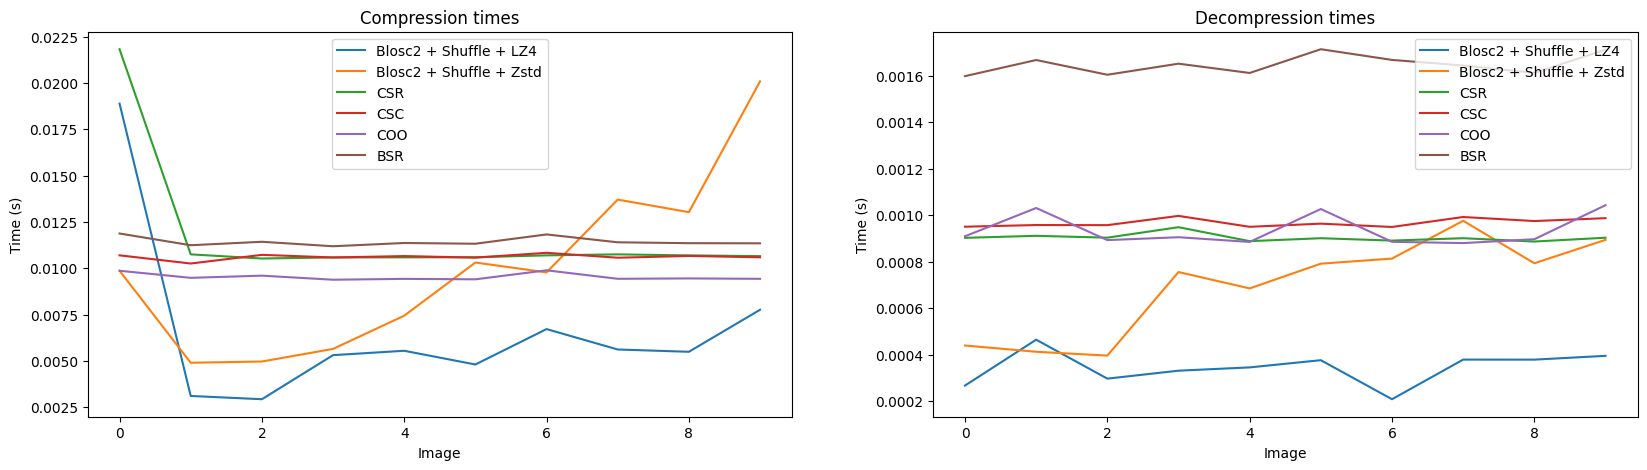

In [17]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
# Increase the font size of all elements by 1.5 times
#plt.rcParams.update({'font.size': 1.5 * plt.rcParams['font.size']})
# Increase the font size of axes labels
# for a in ax.flat:
#     a.tick_params(axis='both', which='major', labelsize=1.5 * plt.rcParams['font.size'])
#     a.xaxis.label.set_size(1.5 * plt.rcParams['font.size'])
#     a.yaxis.label.set_size(1.5 * plt.rcParams['font.size'])

for k, v in ctimes.items():
    ax[0].plot(v, label=k)
    #ax[0].set_ylim(bottom=0)
    ax[0].set_title("Compression times")
    ax[0].set_xlabel("Image")
    ax[0].set_ylabel("Time (s)")
    ax[0].legend()
for k, v in dtimes.items():
    ax[1].plot(v, label=k)
    #ax[1].set_ylim(bottom=0)
    ax[1].set_title("Decompression times")
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Time (s)")
    ax[1].legend()
plt.show()

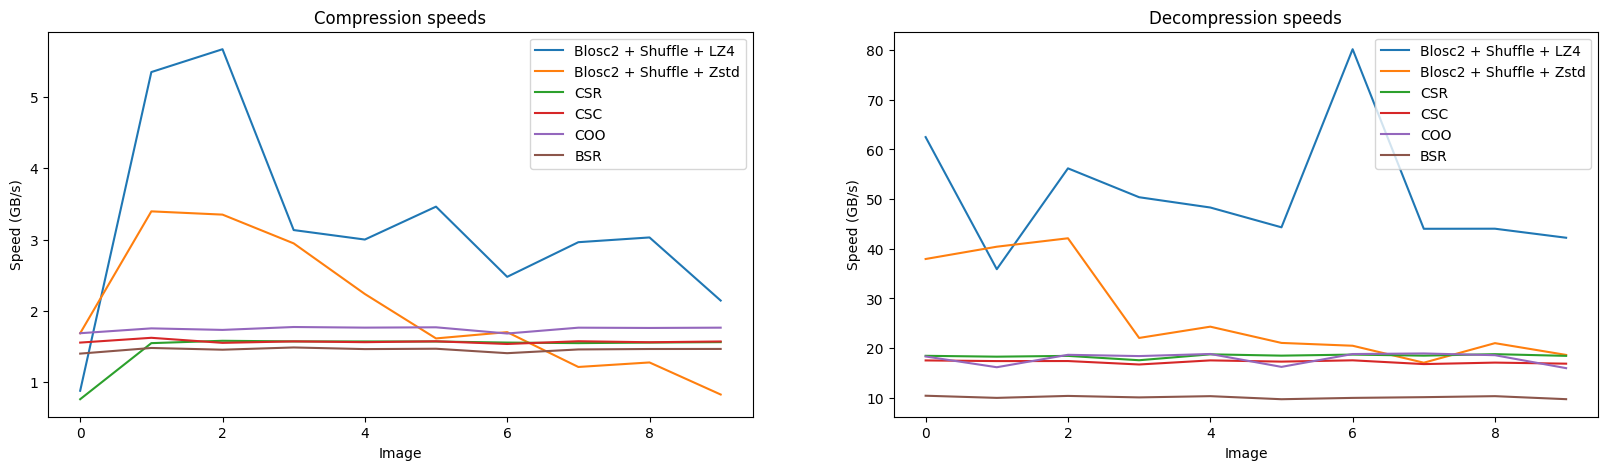

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
#plt.subplots_adjust(hspace=0.5, wspace=0.5)
for k, v in cspeeds.items():
    ax[0].plot(v, label=k)
    #ax[0].set_ylim(0, max(v) * 1.1)
    ax[0].set_title("Compression speeds")
    ax[0].set_xlabel("Image")
    ax[0].set_ylabel("Speed (GB/s)")
    ax[0].legend()
for k, v in dspeeds.items():
    ax[1].plot(v, label=k)
    #ax[1].set_ylim(0, max(v) * 1.1)
    ax[1].set_title("Decompression speeds")
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Speed (GB/s)")
    ax[1].legend()
plt.savefig("sparse_image_stack_speeds.png")

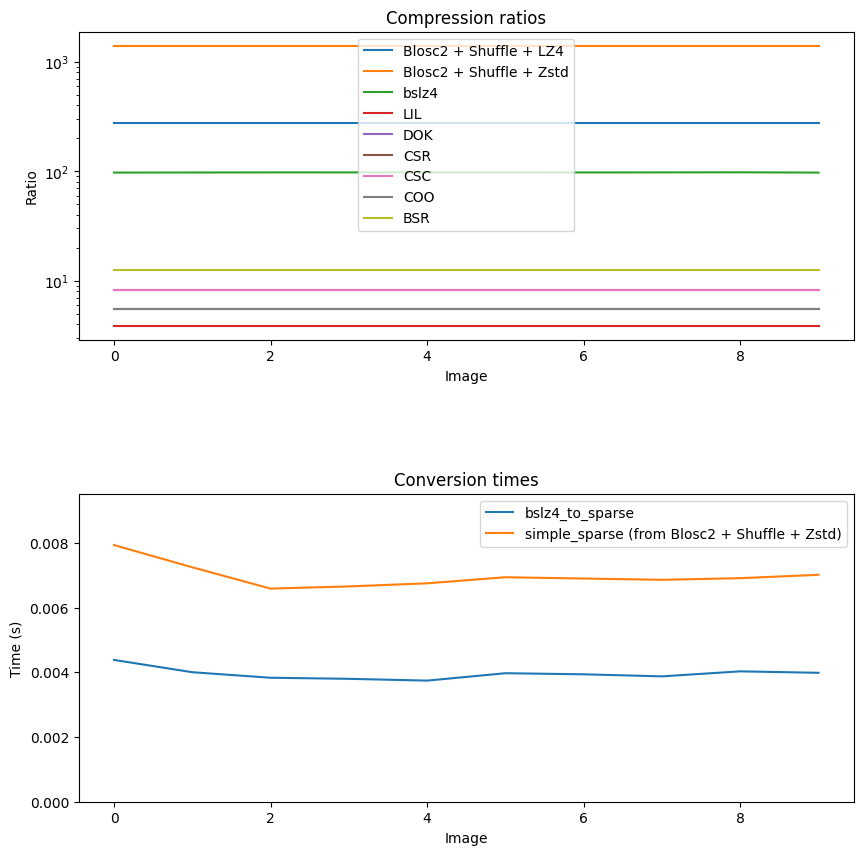

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for k, v in cratios.items():
    ax[0].semilogy(v, label=k)
    ax[0].set_title("Compression ratios")
    ax[0].set_xlabel("Image")
    ax[0].set_ylabel("Ratio")
    ax[0].legend()
for k, v in conv_times.items():
    ax[1].plot(v, label=k)
    ax[1].set_ylim(0, max(v) * 1.2)
    ax[1].set_title("Conversion times")
    ax[1].set_xlabel("Image")
    ax[1].set_ylabel("Time (s)")
    ax[1].legend()
plt.savefig("sparse_image_stack_ratios.png")